# LDA with Highlights

## Imports

In [3]:
import collections
import joblib
import pathlib

import cufflinks as cf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jensenshannon
import ipywidgets

from bbcov import LDAModel, Embedder, QueryMachine

## Data

In [4]:
df_docs = pd.read_pickle("../../preproccessed_data/v4_json_metadata_v2.pkl")
df_docs = df_docs[:500]
df_docs.shape

(500, 18)

In [5]:
df_docs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0001418189999fea7f7cbe3e82703d71c85a6fe5 to 046a56d635edc933ed8f30ccf1ae9fd488dfe645
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   title                        500 non-null    object        
 1   abstract                     500 non-null    object        
 2   text                         500 non-null    object        
 3   sections                     500 non-null    object        
 4   ref_captions                 500 non-null    object        
 5   all_text                     500 non-null    object        
 6   source_x                     476 non-null    object        
 7   doi                          473 non-null    object        
 8   pmcid                        210 non-null    object        
 9   pubmed_id                    364 non-null    float64       
 10  license                      476 non-nu

In [6]:
df_docs.head()

,title,abstract,text,sections,ref_captions,all_text,source_x,doi,pmcid,pubmed_id,license,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file
sha,,,,,,,,,,,,,,,,,,
0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,Results\nIsolation of FIPV positive cells\nCat...,Surface expression of the monocyte marker (A);...,Feline infectious peritonitis virus (FIPV) pos...,Elsevier,10.1016/j.vetmic.2006.11.026,NaN,17188823.0,els-covid,2007-03-31,"Cornelissen, E.; Dewerchin, H.L.; Van Hamme, E...",Veterinary Microbiology,NaN,NaN,True,custom_license
00016663c74157a66b4d509d5c4edffd5391bbe0,,,Viruses are increasingly recognised as pathoge...,Burden of disease studies\nAn integrated molec...,Scheme for foodborne virus tracking. Virus det...,\nViruses are increasingly recognised as patho...,Elsevier,10.1533/9781845691394.1.77,NaN,NaN,els-covid,2006-12-31,"Duizer, E.; Koopmans, M.",Emerging Foodborne Pathogens,NaN,NaN,True,custom_license
0005d253951fedc237715a37db147032eea28912,,,Synthesized by William Prusoff in the late 195...,\nLuis Mené ndez-Arias,//dx.doi.org/10.1016/j.coviro.2014.08.002 1879...,\nSynthesized by William Prusoff in the late 1...,Elsevier,10.1016/j.coviro.2014.08.002,NaN,25155454.0,els-covid,2014-10-31,"Menéndez-Arias, Luis; Richman, Douglas D",Current Opinion in Virology,NaN,NaN,True,custom_license
000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a,Correlation between antimicrobial consumption ...,Objectives: This study was conducted to invest...,The incidence of health-care-associated infect...,Antimicrobial agents and consumption\nCorrelat...,(A) Rates of methicillin-resistant Staphylococ...,Objectives: This study was conducted to invest...,Elsevier,10.1016/j.jmii.2013.10.008,NaN,24388582.0,els-covid,2015-08-31,"Lai, Chih-Cheng; Chu, Chen-Chen; Cheng, Aristi...","Journal of Microbiology, Immunology and Infection",NaN,NaN,True,custom_license
000b7d1517ceebb34e1e3e817695b6de03e2fa78,Supplementary Information An eco-epidemiologic...,,- Figure S1 : Phylogeny of all sequences belon...,,Table S4. Bats cytochrome b sequences data set...,\n- Figure S1 : Phylogeny of all sequences bel...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


## LDA Model

In [7]:
import en_core_sci_md

nlp = en_core_sci_md.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 2_000_000  # maximal number of characters in text

In [8]:
def spacy_tokenizer(sentence):
    return [token.lemma_ for token in nlp(sentence) if not (
        token.like_url or
        token.like_email or
        token.like_num or
        token.is_stop or
        token.is_punct or
        token.is_space or
        token.is_bracket or
        token.is_punct or
        len(token)==1)]

In [9]:
vectorizer = joblib.load('../../stan/1_topic_modeling_lda/tf_vectorizer.csv')
lda = joblib.load('../../stan/1_topic_modeling_lda/lda.csv')

In [10]:
lda_model = LDAModel(vectorizer, lda)
lda_embedder = Embedder(lda_model)

In [11]:
query_machine = QueryMachine(lda_embedder, df_docs, 'text', jensenshannon)

## Create Query Widget with Exclusions

In [12]:
min_year = df_docs.publish_time.min().year
max_year = df_docs.publish_time.max().year
word_counts = df_docs.text.apply(lambda x: len(x.split()))
min_word_count = word_counts.min()
max_word_count = word_counts.max()

@ipywidgets.interact(
    has_title=ipywidgets.Checkbox(
        description="Require Title",
        value=True),
    has_authors=ipywidgets.Checkbox(
        description="Require Authors",
        value=True),
    has_abstract=ipywidgets.Checkbox(
        description="Require Abstract",
        value=False),
    has_journal=ipywidgets.Checkbox(
        description="Require Journal",
        value=False),
    has_doi=ipywidgets.Checkbox(
        description="Require DOI",
        value=False),
    date_range=ipywidgets.IntRangeSlider(
        description="Date Range:",
        continuous_update=False,
        min=min_year,
        max=max_year,
        value=(min_year, max_year),
        layout=ipywidgets.Layout(width='80ch')),
    word_count_range=ipywidgets.IntRangeSlider(
        description="Text Word Count Range:",
        continuous_update=False,
        min=min_word_count,
        max=max_word_count,
        value=(min_word_count, max_word_count),
        style={'description_width': '20ch'},
        layout=ipywidgets.Layout(width='80ch')),
    k=ipywidgets.IntSlider(
        description="Top k:",
        value=3,
        min=1,
        max=30,
        continuous_update=False),
    text=ipywidgets.Textarea(
        description="Query:",
        value="cure for covid-19",
        continuous_update=False,
        layout=ipywidgets.Layout(width='80ch', height='200px')),
    exclusions=ipywidgets.Textarea(
        description="Excluded Phrase:",
        value="",
        continuous_update=False,
        style={'description_width': '30ch'},
        layout=ipywidgets.Layout(width='50ch', height='200px')),
    button=ipywidgets.ToggleButton(description="Submit")
)
def _(k, date_range, word_count_range, has_title,
      has_authors, has_abstract, has_journal, has_doi, text,
       exclusions, button):
    # Year filter
    from_year = pd.Timestamp(year=date_range[0], month=1, day=1)
    to_year = pd.Timestamp(year=date_range[1], month=12, day=31)
    mask = df_docs.publish_time.between(from_year, to_year)
    
    # Word counts
    mask &= word_counts.between(*word_count_range)
    
    if has_title:
        mask &= ~(df_docs.title.isna() | (df_docs.title == ''))
        
    if has_authors:
        mask &= ~(df_docs.authors.isna() | (df_docs.authors == ''))
    
    if has_abstract:
        mask &= ~(df_docs.abstract.isna() | (df_docs.abstract == ''))
        
    if has_journal:
        mask &= ~(df_docs.journal.isna() | (df_docs.journal == ''))
    
    if has_doi:
        mask &= ~(df_docs.doi.isna() | (df_docs.doi == ''))
    
    print(f'Excluding: {exclusions}')
    
    print(f"Searching through {mask.sum()} of {len(mask)} documents")
    print("-" * 8)
    
    if any(mask):
        query_machine.print_query(text, k=k, df_mask=mask, exclusion_query=exclusions or None)

interactive(children=(IntSlider(value=3, continuous_update=False, description='Top k:', max=30, min=1), IntRan…

## LDA - Embed single words
AKA is LDA a good word embedder?

ANSWER: No, it is not

In [16]:
bow = vectorizer.transform(df_docs['text'])

In [17]:
counts = bow.sum(axis=0).A[0]
top_indices = np.argsort(counts)[::-1]
feature_names = vectorizer.get_feature_names()

In [18]:
k = 5000
top_k = {feature_names[ix]: counts[ix] for ix in top_indices[:k] }
top_words = [feature_names[ix] for ix in top_indices[:k] ]

bow_top = vectorizer.transform(top_words)
emb_top = lda.transform(bow_top)


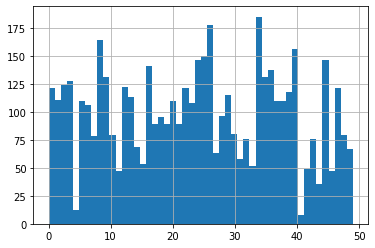

In [19]:
pd.Series(emb_top.argmax(axis=1)).hist(bins=50)

In [20]:
np.unique(np.round(emb_top, 3), axis=0).shape

(90, 50)

## LDA - Embedding parts of the text
Shows that LDA struggles with short text
If long enough, the embeddings are UNIQUE for each "document"

In [87]:
n_char = 200

In [88]:
bow = vectorizer.transform(df_docs['text'].apply(lambda x: x[:n_char]))
emb = lda.transform(bow)

np.unique(np.round(emb, 3), axis=0).shape

(490, 50)

In [31]:
# 50 -> 2 

## Visualization

1. Apply dimensionality reduction (XD -> 2D) to query and database embeddings
2. Visualize


### PCA

In [93]:
# query = 'cure for covid-19'
query = 'government interventions are good'
# query = 'origins of the virus'
# query = 'risk factors and prevention'


color_database = 'pink'
color_query = 'green'

In [94]:
tform = PCA(n_components=2).fit(query_machine.doc_embeddings.values)

X_final = pd.DataFrame(tform.transform(query_machine.doc_embeddings.values),
                         index=query_machine.doc_embeddings.index,
                        
                         columns=['x', 'y'])

In [95]:
X_final = pd.DataFrame(tform.transform(query_machine.doc_embeddings.values),
                         index=query_machine.doc_embeddings.index,
                        
                         columns=['x', 'y'])

X_final = X_final.join(df_docs[['title']])
X_final['colors'] = pd.Series(color_database, index=X_final.index)
X_final['actual_colors'] = X_final['colors']

# query embedding
emb_query = query_machine.embedder(query)
dm_query = tform.transform(emb_query)
new_row = pd.Series({'x': dm_query[0][0],
                           'y': dm_query[0][1],
                           'title': 'QUERY',
                           'colors': color_query})

X_final = X_final.append(new_row, ignore_index=True)

In [96]:
fig = px.scatter(X_final,
                 x='x',
                 y='y',
                 color="colors",
                 color_discrete_map = {color_database: color_database,
                                      color_query: color_query},
                 hover_name='title',
#                  hover_data=X_final.columns
                )
fig.show()

In [98]:
df_docs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0001418189999fea7f7cbe3e82703d71c85a6fe5 to 046a56d635edc933ed8f30ccf1ae9fd488dfe645
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   title                        500 non-null    object        
 1   abstract                     500 non-null    object        
 2   text                         500 non-null    object        
 3   sections                     500 non-null    object        
 4   ref_captions                 500 non-null    object        
 5   all_text                     500 non-null    object        
 6   source_x                     476 non-null    object        
 7   doi                          473 non-null    object        
 8   pmcid                        210 non-null    object        
 9   pubmed_id                    364 non-null    float64       
 10  license                      476 non-nu

In [100]:
df_docs['ref_captions'].values

array(['Surface expression of the monocyte marker (A); absence of surface expression of viral proteins (B); surface expression of MHC I (C) on cytoplasmic FIPV positive cells.\nRe-expression of viral proteins on the plasma membrane after cultivation of FIPV positive cells isolated from three cats with naturally occurring FIP: immunofluorescence pictures (A); kinetics (B).\nBreed, age, sex, FCoV antibody titre and pathological form of FIP from the cats enclosed in this study\nQuantification, identification and determination of viability of FIPV positive cells isolated from pyogranulomas and exudates of 9 FIP cats\nAntibodies and conjugates used in the different staining steps for the identification of macrophage/monocytic cells and viability',
       "Scheme for foodborne virus tracking. Virus detection in patients and possible vectors such as food or water, to determine common source outbreaks.\nRecombination of viruses requires a double infection: two viruses in one cell. NoV is the s